<a href="https://colab.research.google.com/github/Kinnaruo/DeepLearning/blob/main/Week%201/Income.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler

In [78]:
df = pd.read_csv('income.csv')
df.dropna(inplace=True)
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48836,33,Private,245211,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,United-States,<=50K.
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K.
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.


In [79]:
df.dtypes

,0
age,int64
workclass,object
fnlwgt,int64
education,object
education-num,int64
marital-status,object
occupation,object
relationship,object
race,object
sex,object


In [80]:
df['income'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)
categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
df = pd.get_dummies(df, drop_first=True)

In [81]:
X = df.drop('income', axis=1).values
y = df['income'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# undersampling biar kelas >50 dan <=50 seimbang
undersample = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train, y_train = undersample.fit_resample(X_train, y_train)
print("Train class distribution:", np.bincount(y_train))
print("Test class distribution:", np.bincount(y_test))


Train class distribution: [6224 6224]
Test class distribution: [7908 1617]


In [82]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# PyTorch

In [83]:
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

In [84]:
class PyTorchModel(nn.Module):
    def __init__(self, input_dim):
        super(PyTorchModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

model_torch = PyTorchModel(X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model_torch.parameters(), lr=0.001)

In [85]:
for epoch in range(100):
    optimizer.zero_grad()
    outputs = model_torch(X_train_torch)
    loss = criterion(outputs, y_train_torch)
    loss.backward()
    optimizer.step()

y_pred_torch = (model_torch(X_test_torch).detach().numpy() > 0.5).astype(int)

# TensorFlow

In [86]:
model_tf = tf.keras.Sequential([
    tf.keras.Input(shape=(X_train.shape[1],)), #Ini kalau gak mau ada error apalah itu, taro train.shape disini
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_tf.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model_tf.fit(X_train, y_train, epochs=100, verbose=0)

y_pred_tf = (model_tf.predict(X_test) > 0.5).astype(int)

298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step


# Matriks Evaluasi

In [87]:
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred, zero_division=1)
    f1 = f1_score(y_true, y_pred, zero_division=1)
    auc = roc_auc_score(y_true, y_pred) if len(np.unique(y_true)) > 1 else float('nan')

    print(f"{model_name} Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}\n")

    return accuracy, precision, recall, f1, auc

torch_results = evaluate_model(y_test, y_pred_torch, "PyTorch")
tf_results = evaluate_model(y_test, y_pred_tf, "TensorFlow")

PyTorch Evaluation:
Accuracy: 0.7374
Precision: 0.3775
Recall: 0.8423
F1-Score: 0.5213
AUC: 0.7791

TensorFlow Evaluation:
Accuracy: 0.7299
Precision: 0.3587
Recall: 0.7508
F1-Score: 0.4855
AUC: 0.7382



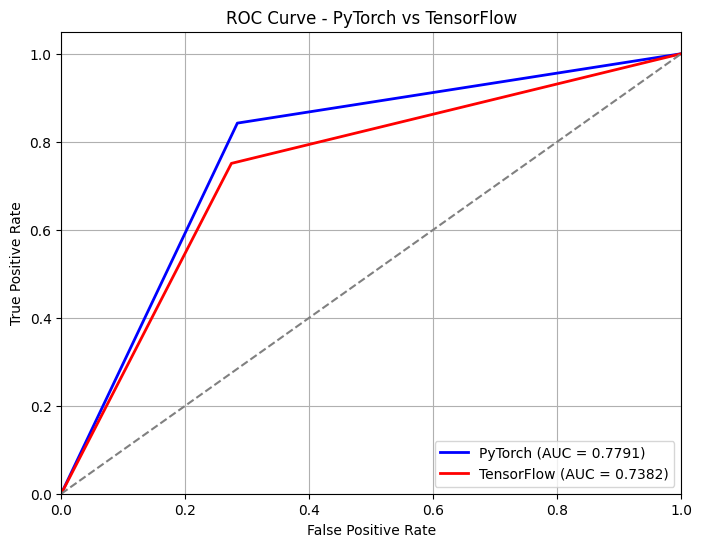

In [93]:
def plot_roc_curves(y_true, y_pred_torch, y_pred_tf):
    fpr_torch, tpr_torch, _ = roc_curve(y_true, y_pred_torch)
    roc_auc_torch = auc(fpr_torch, tpr_torch)

    fpr_tf, tpr_tf, _ = roc_curve(y_true, y_pred_tf)
    roc_auc_tf = auc(fpr_tf, tpr_tf)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_torch, tpr_torch, color='blue', lw=2, label=f'PyTorch (AUC = {roc_auc_torch:.4f})')
    plt.plot(fpr_tf, tpr_tf, color='red', lw=2, label=f'TensorFlow (AUC = {roc_auc_tf:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - PyTorch vs TensorFlow')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

plot_roc_curves(y_test, y_pred_torch, y_pred_tf)

# Matriks Evaluasi

## **Accuracy**
Akurasi mengukur seberapa banyak prediksi yang benar dibandingkan dengan jumlah total data:

$$
Accuracy = \frac{TP + TN}{TP + TN + FP + FN}
$$

Di mana:

- $TP$ = True Positives (Prediksi positif yang benar)  
- $TN$ = True Negatives (Prediksi negatif yang benar)  
- $FP$ = False Positives (Prediksi positif yang salah)  
- $FN$ = False Negatives (Prediksi negatif yang salah)  

## **Precision**

Presisi mengukur seberapa banyak prediksi positif yang benar dibandingkan dengan semua prediksi positif:

$$
Precision = \frac{TP}{TP + FP}
$$

Presisi tinggi berarti model jarang salah ketika memprediksi positif.


## **Recall**

Recall mengukur seberapa banyak sampel positif yang benar-benar terdeteksi oleh model:

$$
Recall = \frac{TP}{TP + FN}
$$

Recall tinggi berarti model berhasil menemukan sebagian besar kasus positif.

## **F1-Score**

F1-Score adalah rata-rata harmonik dari presisi dan recall, yang digunakan untuk keseimbangan antara keduanya:

$$
F1 = 2 \times \frac{Precision \times Recall}{Precision + Recall}
$$

F1-Score berguna jika terdapat ketidakseimbangan kelas, di mana satu kelas lebih dominan dari yang lain.

##**Area Under Curve (AUC-ROC)**

AUC-ROC mengukur seberapa baik model membedakan antara dua kelas dengan menghitung luas di bawah kurva Receiver Operating Characteristic (ROC):

$$
AUC = \int_{0}^{1} TPR(FPR) \, d(FPR)
$$

Di mana:

- $TPR = \frac{TP}{TP + FN}$ (True Positive Rate / Recall)  
- $FPR = \frac{FP}{FP + TN}$ (False Positive Rate)  

Nilai AUC mendekati 1 menunjukkan model memiliki performa yang baik dalam membedakan antara kelas positif dan negatif.